In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from keras.optimizers import Adagrad, SGD, RMSprop, Adam

Welcome to JupyROOT 6.19/01


Using TensorFlow backend.


In [2]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

SignalFile = TFile.Open("4l-TMVA/tree_ewk_mytrain.root")
BackgroundFile = TFile.Open("4l-TMVA/tree_QCD_mytrain.root")
outputFile = TFile.Open("TMVAOutputDNN.root", "RECREATE")

factory = TMVA.Factory("TMVAClassification", outputFile,
        "!V:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

In [3]:
loader = TMVA.DataLoader("dataset_vbszz")

loader.AddVariable("MJJ")
loader.AddVariable("MZZ")
loader.AddVariable("dYJJ")
loader.AddVariable("PtZZ")
loader.AddVariable("PtZ1")
loader.AddVariable("PtJ1")
loader.AddVariable("PtJ2")
loader.AddVariable("YJ1xJ2")
loader.AddVariable("PtL3")
loader.AddVariable("YZ1Star")
loader.AddVariable("YZ2Star")
loader.AddVariable("PtZZJJOHtZZJJ")

In [4]:
tsignal = SignalFile.Get("tree_NOMINAL")
tbackground = BackgroundFile.Get("tree_NOMINAL")

In [5]:
loader.AddSignalTree(tsignal)
loader.AddBackgroundTree(tbackground) 
loader.SetSignalWeightExpression("weightr")
loader.SetBackgroundWeightExpression("weightr")
mycuts= TCut("YJ1xJ2<0. && MJJ>300. && abs(dYJJ)>2.")
mycutb= TCut("YJ1xJ2<0. && MJJ>300. && abs(dYJJ)>2.")
loader.PrepareTrainingAndTestTree(mycuts,mycutb,
        "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V")

DataSetInfo              : [dataset_vbszz] : Added class "Signal"
                         : Add Tree tree_NOMINAL of type Signal with 223401 events
DataSetInfo              : [dataset_vbszz] : Added class "Background"
                         : Add Tree tree_NOMINAL of type Background with 279340 events


In [6]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=12))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(200, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(100, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(100, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(2, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="sgd",
     metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.save('model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               3900      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               60200     
__________

2019-06-05 10:24:34.610081: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-05 10:24:34.613968: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-05 10:24:34.614643: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55ca2f5ff540 executing computations on platform Host. Devices:
2019-06-05 10:24:34.614658: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-05 10:24:34.678375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-05 10:24:34.678700: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55ca2f6ae9e0 executing computations on platform CUDA. Devices:
2019-06-05 10:24:34.678714: I t

In [8]:
factory.BookMethod(loader, TMVA.Types.kPyKeras, 'PyKeras',
        'H:!V:VarTransform=G:FilenameModel=model.h5:'+\
        'NumEpochs=20:BatchSize=50:'+\
        'TriesEarlyStopping=3')
factory.BookMethod(loader, TMVA.Types.kBDT, "BDTG",
        "!H:!V:NTrees=1000:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=30:MaxDepth=5")

<ROOT.TMVA::MethodBDT object ("BDTG") at 0x55ca2fab37a0>

Factory                  : Booking method: PyKeras
                         : 
PyKeras                  : [dataset_vbszz] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'MJJ' <---> Output : variable 'MJJ'
                         : Input : variable 'MZZ' <---> Output : variable 'MZZ'
                         : Input : variable 'dYJJ' <---> Output : variable 'dYJJ'
                         : Input : variable 'PtZZ' <---> Output : variable 'PtZZ'
                         : Input : variable 'PtZ1' <---> Output : variable 'PtZ1'
                         : Input : variable 'PtJ1' <---> Output : variable 'PtJ1'
                         : Input : variable 'PtJ2' <---> Output : variable 'PtJ2'
                         : Input : variable 'YJ1xJ2' <---> Output : variable 'YJ1xJ2'
                         : Input : variable 'PtL3' <---> Output : varia

2019-06-05 10:24:39.135055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2019-06-05 10:24:39.135077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-06-05 10:24:39.135082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2019-06-05 10:24:39.135087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2019-06-05 10:24:39.135132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 9979 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5)


In [9]:
factory.TrainAllMethods()

Instructions for updating:
Use tf.cast instead.
Train on 114100 samples, validate on 28525 samples
Epoch 1/20
114100/114100 [==============================] - 18s 159us/step - loss: 0.5351 - acc: 0.7198 - val_loss: 0.4614 - val_acc: 0.7671

Epoch 00001: val_loss improved from inf to 0.46136, saving model to dataset_vbszz/weights/TrainedModel_PyKeras.h5
Epoch 2/20
114100/114100 [==============================] - 19s 170us/step - loss: 0.4392 - acc: 0.7808 - val_loss: 0.4250 - val_acc: 0.7877

Epoch 00002: val_loss improved from 0.46136 to 0.42498, saving model to dataset_vbszz/weights/TrainedModel_PyKeras.h5
Epoch 3/20
114100/114100 [==============================] - 20s 177us/step - loss: 0.4335 - acc: 0.7834 - val_loss: 0.4223 - val_acc: 0.7895

Epoch 00003: val_loss improved from 0.42498 to 0.42234, saving model to dataset_vbszz/weights/TrainedModel_PyKeras.h5
Epoch 4/20
114100/114100 [==============================] - 18s 161us/step - loss: 0.4303 - acc: 0.7851 - val_loss: 0.4242 - 

2019-06-05 10:24:47.565486: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [10]:
factory.TestAllMethods()
factory.EvaluateAllMethods()

Factory                  : Test all methods
Factory                  : Test method: PyKeras for Classification performance
                         : 
                         : Load model from file: dataset_vbszz/weights/TrainedModel_PyKeras.h5
PyKeras                  : [dataset_vbszz] : Evaluation of PyKeras on testing sample (142625 events)
                         : Elapsed time for evaluation of 142625 events: 3.11 sec       
Factory                  : Test method: BDTG for Classification performance
                         : 
BDTG                     : [dataset_vbszz] : Evaluation of BDTG on testing sample (142625 events)
                         : Elapsed time for evaluation of 142625 events: 8.21 sec       
Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: PyKeras
                         : 
TFHandler_PyKeras        :      Variable             Mean             RMS     [        Min             Max ]
                         : -----

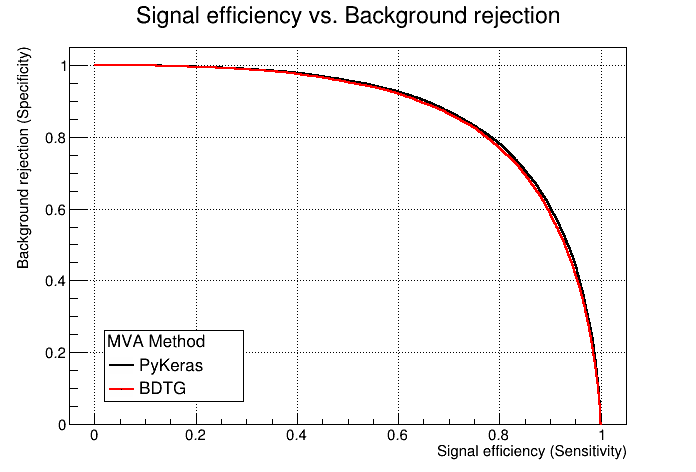

In [11]:
c1 =factory.GetROCCurve(loader);
c1.Draw()